# No ML analysis

## Load libraries and functions
MG script to generate up and anit-up events and apply pT selection

In [1]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import h5py
import awkward as ak
import math
from scipy import stats

## Data Loading

In [2]:
read_file = True
if read_file:
    final_df = pd.read_csv('./uubar.csv')
    print(tabulate(final_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------+-----------+-----------+-----------+------------+----------------+------------------+------------------+------------------+----------------+---------+-----------+-----------+-----------+------------+----------------+------------------+------------------+------------------+----------------+---------+------------+------------+------------+------------+---------+------------+------------+------------+------------+---------+-----------+-----------+-----------+------------+---------+-----------+-----------+-----------+------------+----------------+--------------+--------------------+------------+
|    

In [3]:
print(final_df.shape)
print(final_df.columns)

(35240, 69)
Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'jet_type'],
 

In [7]:
print(final_df['jet_type'].values)
print(final_df['Q_1_0.7'].values)

[1. 1. 1. ... 0. 0. 0.]
[ 0.17313294  0.27073047  0.29452736 ...  0.04030215 -0.2646635
 -1.30635199]


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Define kappa values and matching column names
kappas = [0, 0.3, 0.5, 0.7, 1]
kappa_cols = {
    0: 'Q_1_0',
    0.3: 'Q_1_0.3',
    0.5: 'Q_1_0.5',
    0.7: 'Q_1_0.7',
    1: 'Q_1_1'
}

# Extract labels (jet_type: 1 for up, 0 for anti-up)
labels = final_df['jet_type'].values

# Compute AUC for each kappa
aucs = {}
for kappa in kappas:
    col = kappa_cols[kappa]
    scores = final_df[col].values
    # Compute AUC; flip scores if necessary to ensure >0.5 (assumes positive Q_j favors up jets)
    auc = roc_auc_score(labels, scores)
    if auc < 0.5:
        auc = roc_auc_score(labels, -scores)
    aucs[kappa] = auc
    print(f"AUC for κ={kappa}: {auc:.4f}")

# Find the best kappa and its AUC
best_kappa = max(aucs, key=aucs.get)
best_auc = aucs[best_kappa]
print(f"\nBest traditional Q_κ: κ={best_kappa}, AUC={best_auc:.4f}")

AUC for κ=0: 0.5793
AUC for κ=0.3: 0.5922
AUC for κ=0.5: 0.5966
AUC for κ=0.7: 0.6003
AUC for κ=1: 0.6033

Best traditional Q_κ: κ=1, AUC=0.6033


ROC data for κ=0: AUC=0.5793 (flipped: False)
ROC data for κ=0.3: AUC=0.5922 (flipped: False)
ROC data for κ=0.5: AUC=0.5966 (flipped: False)
ROC data for κ=0.7: AUC=0.6003 (flipped: False)
ROC data for κ=1: AUC=0.6033 (flipped: False)


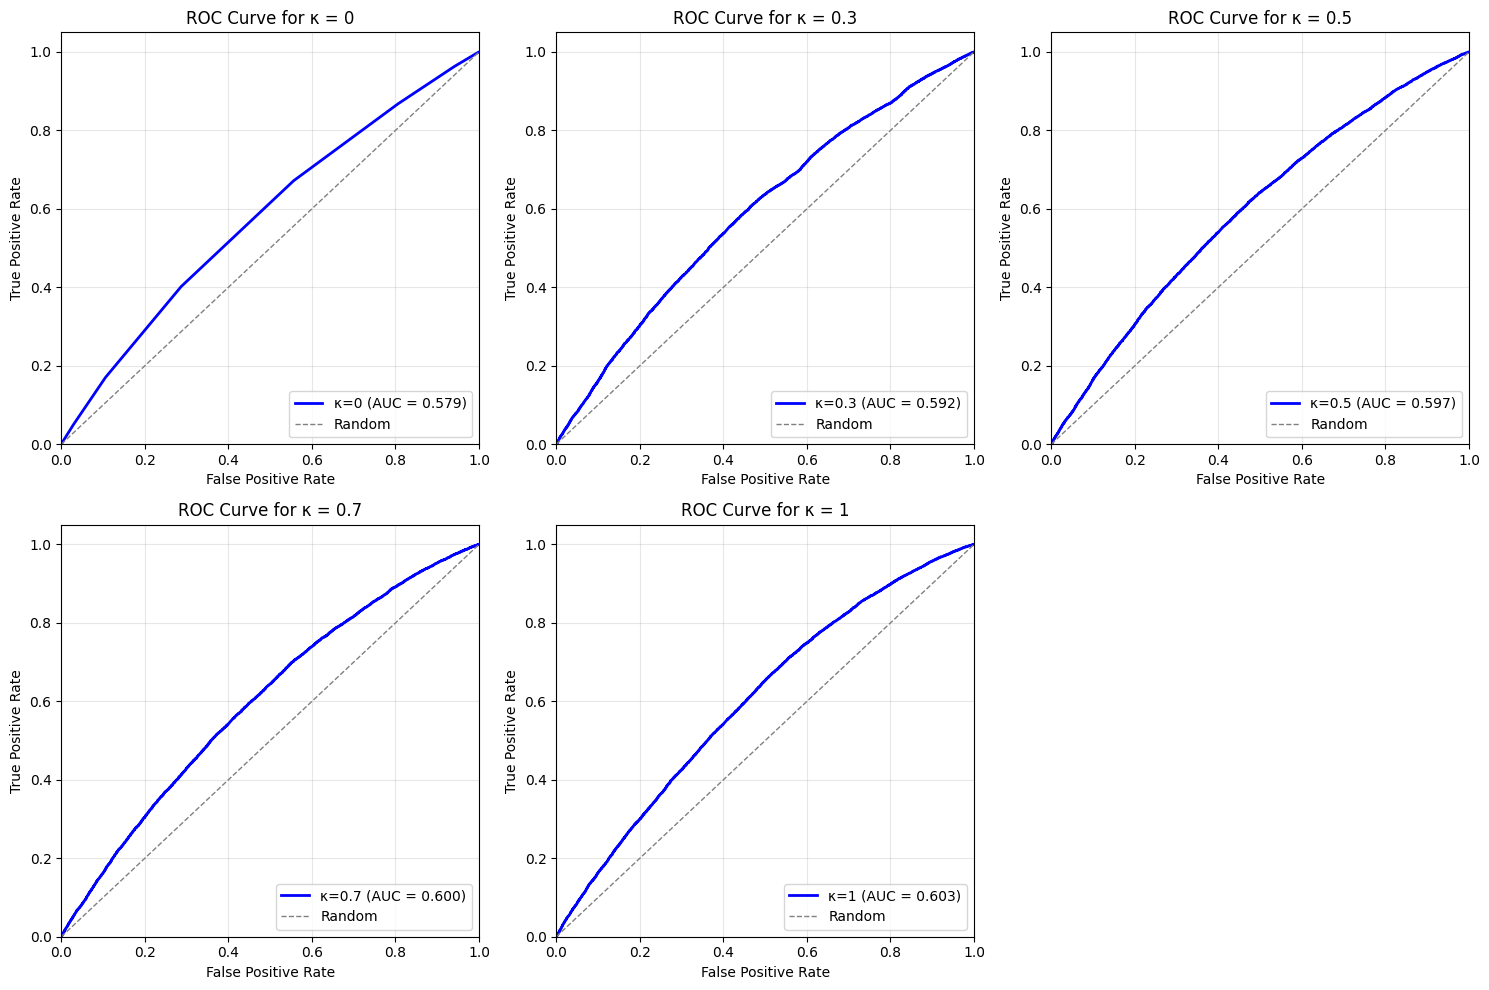

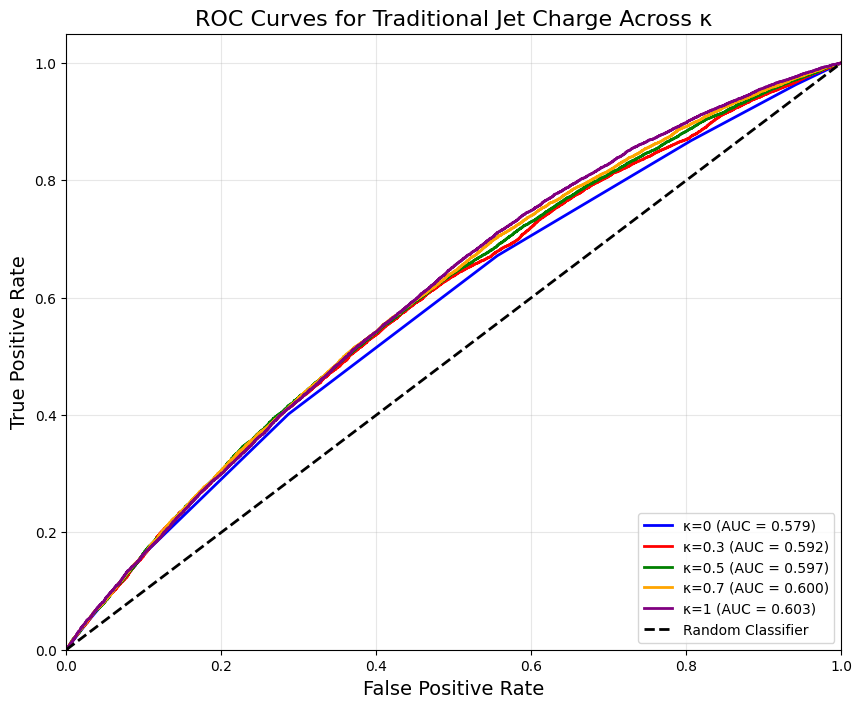


Summary for Table 2:
Best traditional Q_κ: κ=1, AUC=0.6033


In [19]:
# Assuming kappas, kappa_cols, and labels are already defined from the AUC cell
# If not, make sure you ran the AUC computation cell first

# List to store FPR, TPR for each kappa
roc_data = {}

for kappa in kappas:
    col = kappa_cols[kappa]
    scores = final_df[col].values
    
    # Compute ROC without flipping
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)  # Use roc_auc_score instead of auc()
    
    # If AUC < 0.5, flip scores and recompute
    flipped = False
    if roc_auc < 0.5:
        fpr, tpr, _ = roc_curve(labels, -scores)
        roc_auc = roc_auc_score(labels, -scores)
        flipped = True
    
    roc_data[kappa] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc, 'flipped': flipped}
    print(f"ROC data for κ={kappa}: AUC={roc_auc:.4f} (flipped: {flipped})")

# Plot 1: Individual ROC curves for each kappa (subplots)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()  # Flatten for easy indexing (5 kappas, use first 5)

for idx, kappa in enumerate(kappas):
    if idx < 5:  # Only 5 kappas
        fpr = roc_data[kappa]['fpr']
        tpr = roc_data[kappa]['tpr']
        auc_val = roc_data[kappa]['auc']
        
        axs[idx].plot(fpr, tpr, lw=2, color='blue', label=f'κ={kappa} (AUC = {auc_val:.3f})')
        axs[idx].plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random')
        axs[idx].set_xlim([0.0, 1.0])
        axs[idx].set_ylim([0.0, 1.05])
        axs[idx].set_xlabel('False Positive Rate')
        axs[idx].set_ylabel('True Positive Rate')
        axs[idx].set_title(f'ROC Curve for κ = {kappa}')
        axs[idx].legend(loc='lower right')
        axs[idx].grid(True, alpha=0.3)

# Hide the unused subplot
axs[5].set_visible(False)
plt.tight_layout()
plt.savefig('roc_individual.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Overlaid ROC curves for all kappas
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # One color per kappa

for idx, kappa in enumerate(kappas):
    fpr = roc_data[kappa]['fpr']
    tpr = roc_data[kappa]['tpr']
    auc_val = roc_data[kappa]['auc']
    plt.plot(fpr, tpr, lw=2, color=colors[idx], label=f'κ={kappa} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Traditional Jet Charge Across κ', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary for paper
print("\nSummary for Table 2:")
print(f"Best traditional Q_κ: κ={best_kappa}, AUC={best_auc:.4f}")

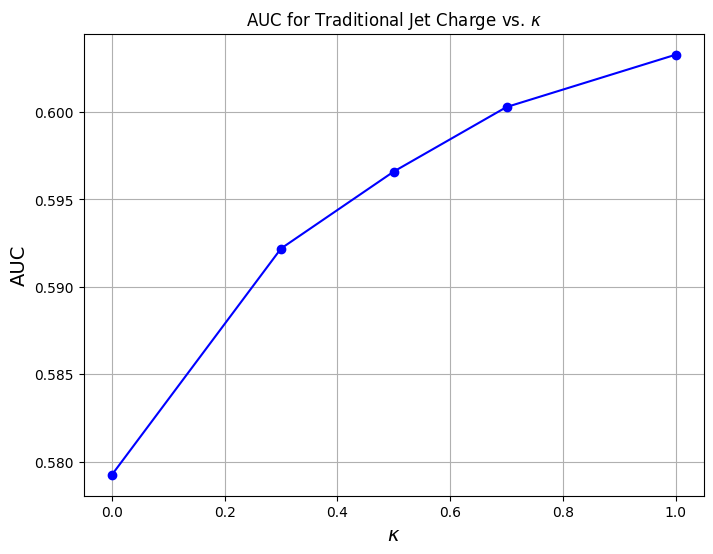

In [20]:
import matplotlib.pyplot as plt

# Plot AUC vs kappa
plt.figure(figsize=(8, 6))
plt.plot(list(aucs.keys()), list(aucs.values()), marker='o', linestyle='-', color='blue')
plt.xlabel(r'$\kappa$', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('AUC for Traditional Jet Charge vs. $\kappa$')
plt.grid(True)
plt.savefig('auc_vs_kappa.png')  # Save for paper insertion
plt.show()

In [10]:
from sklearn.metrics import accuracy_score

# Compute accuracy for each kappa
accs = {}
for kappa in kappas:
    col = kappa_cols[kappa]
    scores = final_df[col].values
    # Threshold at 0: predict 1 (up) if >0, 0 (anti-up) if <=0
    preds = (scores > 0).astype(int)
    acc = accuracy_score(labels, preds)
    # If acc <0.5, flip threshold (handles potential label inversion)
    if acc < 0.5:
        preds = (scores < 0).astype(int)
        acc = accuracy_score(labels, preds)
    accs[kappa] = acc
    print(f"Accuracy for κ={kappa}: {acc:.4f}")

# Find the best kappa and its accuracy
best_kappa = max(accs, key=accs.get)
best_acc = accs[best_kappa]
print(f"\nBest traditional Q_κ: κ={best_kappa}, Accuracy={best_acc:.4f}")

Accuracy for κ=0: 0.5656
Accuracy for κ=0.3: 0.5699
Accuracy for κ=0.5: 0.5718
Accuracy for κ=0.7: 0.5727
Accuracy for κ=1: 0.5726

Best traditional Q_κ: κ=0.7, Accuracy=0.5727


In [ ]:
# Define kappa values and matching column names
kappas = [0, 0.3, 0.5, 0.7, 1]
kappa_cols = {
    0: 'Q_2_0',
    0.3: 'Q_2_0.3',
    0.5: 'Q_2_0.5',
    0.7: 'Q_2_0.7',
    1: 'Q_2_1'
}

# Extract labels (jet_type: 1 for up, 0 for anti-up)
labels = final_df['jet_type'].values

# Compute AUC for each kappa
aucs = {}
for kappa in kappas:
    col = kappa_cols[kappa]
    scores = final_df[col].values
    # Compute AUC; flip scores if necessary to ensure >0.5 (assumes positive Q_j favors up jets)
    auc = roc_auc_score(labels, scores)
    if auc < 0.5:
        auc = roc_auc_score(labels, -scores)
    aucs[kappa] = auc
    print(f"AUC for κ={kappa}: {auc:.4f}")

# Find the best kappa and its AUC
best_kappa = max(aucs, key=aucs.get)
best_auc = aucs[best_kappa]
print(f"\nBest traditional Q_κ: κ={best_kappa}, AUC={best_auc:.4f}")

AUC for κ=0: 0.5664
AUC for κ=0.3: 0.5772
AUC for κ=0.5: 0.5825
AUC for κ=0.7: 0.5879
AUC for κ=1: 0.5941

Best traditional Q_κ: κ=1, AUC=0.5941
